In [3]:

import os
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.15.0
GPU Available: []


In [4]:
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.15.0
GPU Available: []


In [5]:


## 2. Define the DarijaSpeechRecognizer Class

class DarijaSpeechRecognizer:
    def __init__(self, data_path='augmented_data.csv', audio_base_path='audio/augmented_dataset'):
        """
        Initialize the Darija Speech Recognition system
        
        Args:
            data_path: Path to the CSV file containing audio metadata
            audio_base_path: Base path to audio files
        """
        self.data_path = data_path
        self.audio_base_path = audio_base_path
        self.model = None
        self.label_encoder = LabelEncoder()
        self.feature_dim = 40  # MFCC features
        self.max_length = 100  # Maximum sequence length
        
    def load_data(self):
        """Load and preprocess the dataset"""
        print("Loading dataset...")
        self.df = pd.read_csv(self.data_path, delimiter=';')
        print(f"Dataset loaded: {len(self.df)} samples")
        print(f"Intents: {self.df['intent'].unique()}")
        print(f"Darija phrases: {self.df['phrase_darija'].nunique()} unique phrases")
        
        # Display dataset info
        print("\nDataset Information:")
        print(self.df.info())
        print("\nIntent Distribution:")
        print(self.df['intent'].value_counts())
        
        return self.df
    
    def extract_features(self, audio_path, sr=22050):
        """
        Extract MFCC features from audio file
        
        Args:
            audio_path: Path to audio file
            sr: Sample rate
            
        Returns:
            mfcc_features: Extracted MFCC features
        """
        try:
            # Load audio file
            audio, sample_rate = librosa.load(audio_path, sr=sr, duration=3.0)
            
            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=self.feature_dim)
            
            # Pad or truncate to fixed length
            if mfccs.shape[1] < self.max_length:
                mfccs = np.pad(mfccs, ((0, 0), (0, self.max_length - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :self.max_length]
                
            return mfccs.T  # Transpose to (time_steps, features)
            
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return np.zeros((self.max_length, self.feature_dim))
    
    def prepare_features(self):
        """Extract features from all audio files"""
        print("Extracting features from audio files...")
        features = []
        labels = []
        valid_indices = []
        
        for idx, row in self.df.iterrows():
            if idx % 50 == 0:
                print(f"Processing {idx}/{len(self.df)} files...")
                
            # Construct full audio path
            audio_path = os.path.join(self.audio_base_path, row['filename_audio'])
            
            if os.path.exists(audio_path):
                # Extract features
                mfcc_features = self.extract_features(audio_path)
                features.append(mfcc_features)
                labels.append(row['intent'])
                valid_indices.append(idx)
            else:
                print(f"Audio file not found: {audio_path}")
        
        self.features = np.array(features)
        self.labels = np.array(labels)
        self.valid_indices = valid_indices
        
        print(f"Features shape: {self.features.shape}")
        print(f"Labels shape: {self.labels.shape}")
        
        # Encode labels
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)
        self.num_classes = len(self.label_encoder.classes_)
        
        print(f"Number of classes: {self.num_classes}")
        print(f"Classes: {self.label_encoder.classes_}")
        
        return self.features, self.encoded_labels
    
    def build_model(self):
        """Build the neural network model"""
        print("Building model...")
        
        model = keras.Sequential([
            # LSTM layers for sequence processing
            keras.layers.LSTM(128, return_sequences=True, input_shape=(self.max_length, self.feature_dim)),
            keras.layers.Dropout(0.3),
            keras.layers.LSTM(64, return_sequences=True),
            keras.layers.Dropout(0.3),
            keras.layers.LSTM(32),
            keras.layers.Dropout(0.3),
            
            # Dense layers for classification
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        self.model = model
        print("Model built successfully!")
        print(model.summary())
        
        return model
    
    def train_model(self, epochs=50, batch_size=32, validation_split=0.2):
        """Train the speech recognition model"""
        print("Training model...")
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            self.features, self.encoded_labels, 
            test_size=0.2, random_state=42, stratify=self.encoded_labels
        )
        
        # Store indices for error analysis
        train_indices, test_indices = train_test_split(
            range(len(self.features)), 
            test_size=0.2, random_state=42, stratify=self.encoded_labels
        )
        self.test_indices = test_indices
        
        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5),
            keras.callbacks.ModelCheckpoint('models/best_darija_model.h5', save_best_only=True)
        ]
        
        # Create models directory if it doesn't exist
        os.makedirs('models', exist_ok=True)
        
        # Train the model
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate the model
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
        print(f"Final Test Loss: {test_loss:.4f}")
        
        # Generate predictions for detailed evaluation
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_classes, 
                                  target_names=self.label_encoder.classes_))
        
        # Store test data for further analysis
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred_classes = y_pred_classes
        self.history = history
        
        # Display class distribution in test set
        test_counts = pd.Series(y_test).value_counts().sort_index()
        print("\nTest Set Class Distribution:")
        for i, count in enumerate(test_counts):
            class_name = self.label_encoder.classes_[i]
            print(f"{class_name}: {count}")
        
        # Show confusion matrix details
        cm = confusion_matrix(y_test, y_pred_classes)
        print("\nConfusion Matrix:")
        cm_df = pd.DataFrame(cm, index=self.label_encoder.classes_, columns=self.label_encoder.classes_)
        print(cm_df)
        
        # Error analysis
        error_mask = (y_test != y_pred_classes)
        if error_mask.sum() > 0:
            print(f"\nMisclassified samples: {error_mask.sum()}")
            # Show some misclassified examples
            for i, idx in enumerate(np.where(error_mask)[0][:5]):  # Show first 5 errors
                true_label = self.label_encoder.classes_[y_test[idx]]
                pred_label = self.label_encoder.classes_[y_pred_classes[idx]]
                print(f"Sample {idx}: True={true_label}, Predicted={pred_label}")
        
        return history
    
    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy', linewidth=2)
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Loss
        ax2.plot(self.history.history['loss'], label='Training Loss', linewidth=2)
        ax2.plot(self.history.history['val_loss'], label='Validation Loss', linewidth=2)
        ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('plots/training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_confusion_matrix(self):
        """Plot confusion matrix"""
        cm = confusion_matrix(self.y_test, self.y_pred_classes)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_,
                   cbar_kws={'label': 'Count'})
        plt.title('Confusion Matrix - Darija Speech Recognition', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Intent', fontsize=12)
        plt.ylabel('True Intent', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('plots/confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_model_for_deployment(self, model_dir='deployment_model'):
        """
        Save the complete model package for web app deployment
        """
        print("Saving model for deployment...")
        
        # Create deployment directory
        os.makedirs(model_dir, exist_ok=True)
        
        # Save the trained model
        model_path = os.path.join(model_dir, 'darija_speech_model.h5')
        self.model.save(model_path)
        
        # Save label encoder
        encoder_path = os.path.join(model_dir, 'label_encoder.pkl')
        with open(encoder_path, 'wb') as f:
            pickle.dump(self.label_encoder, f)
        
        # Save model configuration and metadata
        config = {
            'model_path': 'darija_speech_model.h5',
            'encoder_path': 'label_encoder.pkl',
            'feature_dim': self.feature_dim,
            'max_length': self.max_length,
            'num_classes': self.num_classes,
            'classes': self.label_encoder.classes_.tolist(),
            'sample_rate': 22050,
            'audio_duration': 3.0
        }
        
        config_path = os.path.join(model_dir, 'model_config.json')
        with open(config_path, 'w', encoding='utf-8') as f:
            json.dump(config, f, indent=2, ensure_ascii=False)
        
        # Save model summary
        with open(os.path.join(model_dir, 'model_summary.txt'), 'w') as f:
            self.model.summary(print_fn=lambda x: f.write(x + '\n'))
        
        # Create a requirements file for deployment
        requirements = [
            'tensorflow>=2.10.0',
            'librosa>=0.9.0',
            'numpy>=1.21.0',
            'pandas>=1.3.0',
            'scikit-learn>=1.0.0',
            'streamlit>=1.20.0',
            'pickle-mixin>=1.0.2'
        ]
        
        with open(os.path.join(model_dir, 'requirements.txt'), 'w') as f:
            f.write('\n'.join(requirements))
        
        print(f"✅ Model package saved to '{model_dir}/' directory")
        print(f"✅ Model file: {model_path}")
        print(f"✅ Label encoder: {encoder_path}")
        print(f"✅ Configuration: {config_path}")
        print(f"✅ Requirements: {os.path.join(model_dir, 'requirements.txt')}")
        
        return model_dir
    
    def load_trained_model(self, model_dir='deployment_model'):
        """Load a trained model from deployment directory"""
        config_path = os.path.join(model_dir, 'model_config.json')
        
        with open(config_path, 'r', encoding='utf-8') as f:
            config = json.load(f)
        
        # Load model
        model_path = os.path.join(model_dir, config['model_path'])
        self.model = keras.models.load_model(model_path)
        
        # Load encoder
        encoder_path = os.path.join(model_dir, config['encoder_path'])
        with open(encoder_path, 'rb') as f:
            self.label_encoder = pickle.load(f)
        
        # Set configuration
        self.feature_dim = config['feature_dim']
        self.max_length = config['max_length']
        self.num_classes = config['num_classes']
        
        print("✅ Model loaded successfully from deployment package!")
        return config
    
    def predict_audio(self, audio_path):
        """
        Predict the intent of a single audio file
        
        Args:
            audio_path: Path to audio file
            
        Returns:
            predicted_intent: Predicted intent
            confidence: Prediction confidence
        """
        # Extract features
        features = self.extract_features(audio_path)
        features = features.reshape(1, self.max_length, self.feature_dim)
        
        # Make prediction
        prediction = self.model.predict(features, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)
        
        # Get all probabilities for detailed output
        all_probs = {
            self.label_encoder.classes_[i]: float(prediction[0][i]) 
            for i in range(len(self.label_encoder.classes_))
        }
        
        # Decode prediction
        predicted_intent = self.label_encoder.inverse_transform([predicted_class])[0]
        
        return predicted_intent, confidence, all_probs
    
    def batch_predict(self, audio_files):
        """Predict intents for multiple audio files"""
        results = []
        for audio_file in audio_files:
            intent, confidence, probs = self.predict_audio(audio_file)
            results.append({
                'file': audio_file,
                'predicted_intent': intent,
                'confidence': confidence,
                'all_probabilities': probs
            })
        return results


In [6]:


## 3. Initialize and Load Data

# Initialize the speech recognizer
recognizer = DarijaSpeechRecognizer(
    data_path='augmented_data.csv',
    audio_base_path='audio/augmented_dataset'
)

# Load data
print("=" * 50)
print("LOADING DATASET")
print("=" * 50)
df = recognizer.load_data()


LOADING DATASET
Loading dataset...
Dataset loaded: 252 samples
Intents: ['open_door' 'turn_on_light' 'turn_off_light']
Darija phrases: 6 unique phrases

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   filename_audio    252 non-null    object
 1   phrase_darija     252 non-null    object
 2   transcription_fr  252 non-null    object
 3   intent            252 non-null    object
 4   speaker           252 non-null    object
dtypes: object(5)
memory usage: 10.0+ KB
None

Intent Distribution:
intent
open_door         84
turn_on_light     84
turn_off_light    84
Name: count, dtype: int64


In [7]:

## 4. Feature Extraction

print("\n" + "=" * 50)
print("FEATURE EXTRACTION")
print("=" * 50)

# Extract features from all audio files
features, labels = recognizer.prepare_features()

print(f"\n✅ Feature extraction completed!")
print(f"Final feature matrix shape: {features.shape}")
print(f"Final labels shape: {labels.shape}")



FEATURE EXTRACTION
Extracting features from audio files...
Processing 0/252 files...
Processing 50/252 files...
Processing 100/252 files...
Processing 150/252 files...
Processing 200/252 files...
Processing 250/252 files...
Features shape: (252, 100, 40)
Labels shape: (252,)
Number of classes: 3
Classes: ['open_door' 'turn_off_light' 'turn_on_light']

✅ Feature extraction completed!
Final feature matrix shape: (252, 100, 40)
Final labels shape: (252,)


In [8]:


## 5. Model Building

print("\n" + "=" * 50)
print("MODEL BUILDING")
print("=" * 50)

# Build the neural network model
model = recognizer.build_model()




MODEL BUILDING
Building model...


Model built successfully!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          86528     
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           49408     
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                            

In [9]:
## 6. Model Training

print("\n" + "=" * 50)
print("MODEL TRAINING")
print("=" * 50)

# Create necessary directories
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# Train the model
history = recognizer.train_model(epochs=50, batch_size=32)

print("\n✅ Training completed!")



MODEL TRAINING
Training model...
Epoch 1/50


7/7 [==============================] - 10s 399ms/step - loss: 1.0982 - accuracy: 0.3333 - val_loss: 1.0821 - val_accuracy: 0.3137 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - 1s 153ms/step - loss: 1.0839 - accuracy: 0.4129 - val_loss: 1.0829 - val_accuracy: 0.3922 - lr: 0.0010
Epoch 3/50
7/7 [==============================] - 1s 158ms/step - loss: 1.0593 - accuracy: 0.4876 - val_loss: 1.0660 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 4/50
7/7 [==============================] - 1s 156ms/step - loss: 1.0607 - accuracy: 0.4229 - val_loss: 1.0373 - val_accuracy: 0.5490 - lr: 0.0010
Epoch 5/50
7/7 [==============================] - 1s 156ms/step - loss: 1.0165 - accuracy: 0.4577 - val_loss: 1.0240 - val_accuracy: 0.5098 - lr: 0.0010
Epoch 6/50
7/7 [==============================] - 1s 154ms/step - loss: 1.0027 - accuracy: 0.5224 - val_loss: 1.0051 - val_accuracy: 0.5686 - lr: 0.0010
Epoch 7/50
7/7 [=============================


RESULTS VISUALIZATION
Plotting training history...


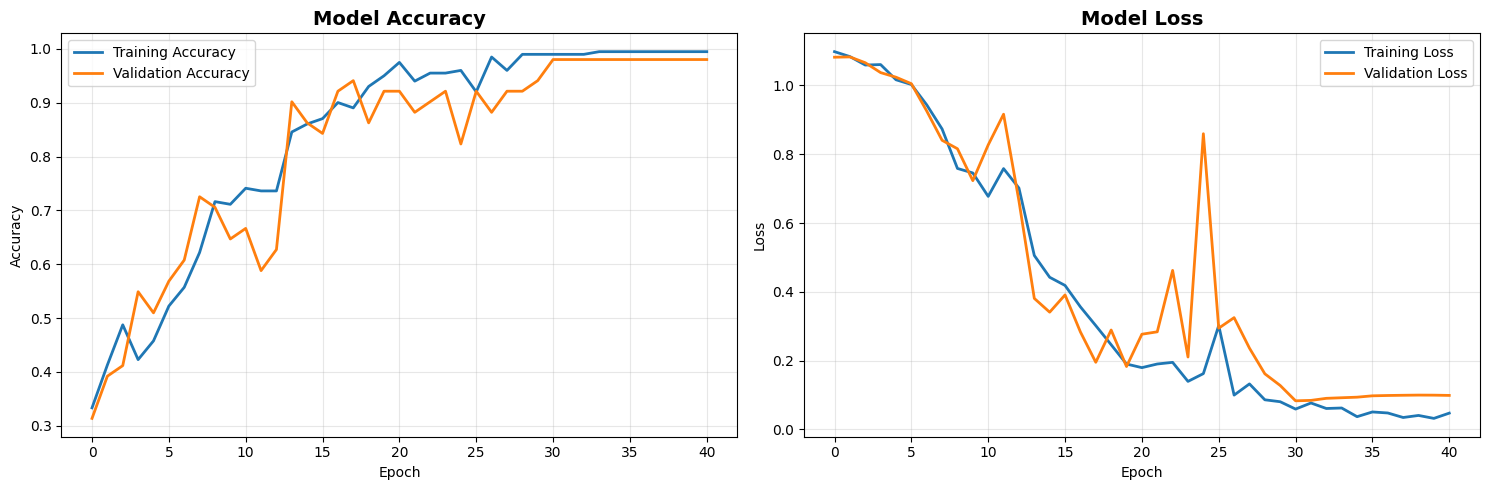

Plotting confusion matrix...


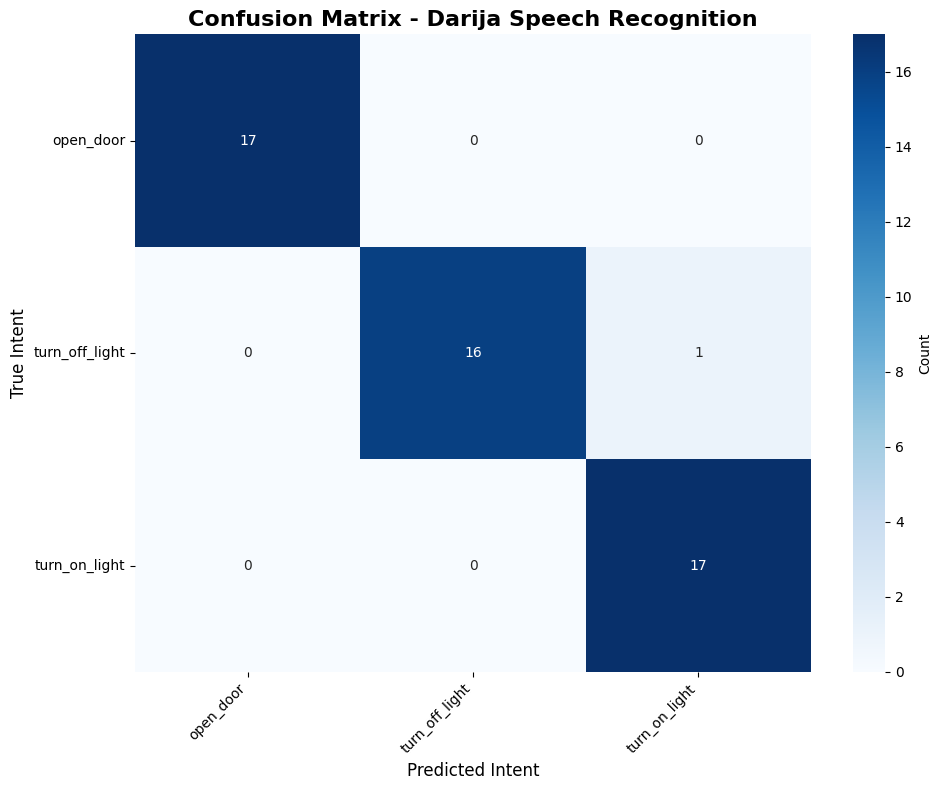


SAVING MODEL FOR DEPLOYMENT
Saving model for deployment...
✅ Model package saved to 'deployment_model/' directory
✅ Model file: deployment_model\darija_speech_model.h5
✅ Label encoder: deployment_model\label_encoder.pkl
✅ Configuration: deployment_model\model_config.json
✅ Requirements: deployment_model\requirements.txt

🎉 Model successfully prepared for deployment!
📁 All files are saved in: deployment_model/

📋 Deployment package contents:
   ├── darija_speech_model.h5     (Trained model)
   ├── label_encoder.pkl          (Label encoder)
   ├── model_config.json          (Model configuration)
   ├── model_summary.txt          (Model architecture)
   └── requirements.txt           (Python dependencies)


In [10]:


## 7. Visualize Results

print("\n" + "=" * 50)
print("RESULTS VISUALIZATION")
print("=" * 50)

# Plot training history
print("Plotting training history...")
recognizer.plot_training_history()

# Plot confusion matrix
print("Plotting confusion matrix...")
recognizer.plot_confusion_matrix()

## 8. Save Model for Deployment

print("\n" + "=" * 50)
print("SAVING MODEL FOR DEPLOYMENT")
print("=" * 50)

# Save the complete model package for web app deployment
deployment_dir = recognizer.save_model_for_deployment('deployment_model')

print(f"\n🎉 Model successfully prepared for deployment!")
print(f"📁 All files are saved in: {deployment_dir}/")
print("\n📋 Deployment package contents:")
print("   ├── darija_speech_model.h5     (Trained model)")
print("   ├── label_encoder.pkl          (Label encoder)")
print("   ├── model_config.json          (Model configuration)")
print("   ├── model_summary.txt          (Model architecture)")
print("   └── requirements.txt           (Python dependencies)")



In [11]:
## 9. Test the Saved Model (Optional)

print("\n" + "=" * 50)
print("TESTING SAVED MODEL")
print("=" * 50)

# Test loading the saved model
test_recognizer = DarijaSpeechRecognizer()
config = test_recognizer.load_trained_model('deployment_model')

print("Model configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Test prediction (uncomment if you have a test audio file)
# test_audio_path = 'path/to/test/audio.wav'
# if os.path.exists(test_audio_path):
#     intent, confidence, all_probs = test_recognizer.predict_audio(test_audio_path)
#     print(f"\n🎤 Test Prediction:")
#     print(f"   Predicted Intent: {intent}")
#     print(f"   Confidence: {confidence:.3f}")
#     print(f"   All Probabilities: {all_probs}")



TESTING SAVED MODEL
✅ Model loaded successfully from deployment package!
Model configuration:
  model_path: darija_speech_model.h5
  encoder_path: label_encoder.pkl
  feature_dim: 40
  max_length: 100
  num_classes: 3
  classes: ['open_door', 'turn_off_light', 'turn_on_light']
  sample_rate: 22050
  audio_duration: 3.0


In [12]:

## 10. Web App Integration Code

print("\n" + "=" * 50)
print("WEB APP INTEGRATION GUIDE")
print("=" * 50)

web_app_code = '''
# Here's how to use this model in a Streamlit web app:

import streamlit as st
import os
import tempfile
from your_model_class import DarijaSpeechRecognizer

@st.cache_resource
def load_model():
    """Load the trained model (cached for performance)"""
    recognizer = DarijaSpeechRecognizer()
    recognizer.load_trained_model('deployment_model')
    return recognizer

def main():
    st.title("🎤 Darija Speech Recognition")
    st.write("Upload an audio file to recognize Darija speech intents")
    
    # Load model
    recognizer = load_model()
    
    # File upload
    uploaded_file = st.file_uploader(
        "Choose an audio file", 
        type=['wav', 'mp3', 'ogg', 'flac']
    )
    
    if uploaded_file is not None:
        # Save uploaded file temporarily
        with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as tmp_file:
            tmp_file.write(uploaded_file.read())
            tmp_path = tmp_file.name
        
        # Display audio player
        st.audio(uploaded_file)
        
        # Make prediction
        if st.button("🔍 Recognize Speech"):
            with st.spinner("Processing audio..."):
                try:
                    intent, confidence, all_probs = recognizer.predict_audio(tmp_path)
                    
                    # Display results
                    st.success(f"**Predicted Intent:** {intent}")
                    st.info(f"**Confidence:** {confidence:.3f}")
                    
                    # Show all probabilities
                    st.write("**All Probabilities:**")
                    for intent_name, prob in sorted(all_probs.items(), 
                                                  key=lambda x: x[1], reverse=True):
                        st.write(f"  - {intent_name}: {prob:.3f}")
                        
                except Exception as e:
                    st.error(f"Error processing audio: {str(e)}")
                finally:
                    # Clean up temporary file
                    os.unlink(tmp_path)

if __name__ == "__main__":
    main()
'''

print("💡 Save the above code as 'streamlit_app.py' in your deployment directory")
print("💡 Run with: streamlit run streamlit_app.py")



WEB APP INTEGRATION GUIDE
💡 Save the above code as 'streamlit_app.py' in your deployment directory
💡 Run with: streamlit run streamlit_app.py


In [13]:

## Summary

print("\n" + "🎉" * 20)
print("TRAINING SUMMARY")
print("🎉" * 20)

print(f"✅ Dataset: {len(df)} samples processed")
print(f"✅ Features: {recognizer.features.shape[0]} audio files converted to MFCC features")
print(f"✅ Model: LSTM-based neural network with {recognizer.num_classes} output classes")
print(f"✅ Classes: {', '.join(recognizer.label_encoder.classes_)}")

if hasattr(recognizer, 'history'):
    final_acc = max(recognizer.history.history['val_accuracy'])
    print(f"✅ Best Validation Accuracy: {final_acc:.4f}")

print(f"✅ Model saved for deployment in: deployment_model/")
print(f"✅ Ready for Streamlit/Flask web app integration!")

print("\n📋 Next Steps:")
print("1. Copy the 'deployment_model/' folder to your web app directory")
print("2. Install requirements: pip install -r deployment_model/requirements.txt")
print("3. Use the provided Streamlit code template")
print("4. Deploy your web app!")



🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
TRAINING SUMMARY
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
✅ Dataset: 252 samples processed
✅ Features: 252 audio files converted to MFCC features
✅ Model: LSTM-based neural network with 3 output classes
✅ Classes: open_door, turn_off_light, turn_on_light
✅ Best Validation Accuracy: 0.9804
✅ Model saved for deployment in: deployment_model/
✅ Ready for Streamlit/Flask web app integration!

📋 Next Steps:
1. Copy the 'deployment_model/' folder to your web app directory
2. Install requirements: pip install -r deployment_model/requirements.txt
3. Use the provided Streamlit code template
4. Deploy your web app!
